# RoBERTa FL

## Variables d'environnement

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# # Id des GPU disponibles : 0 et 1

## Importation

In [1]:
import os
import time
import datetime
from typing import Any, Union, Dict, List
import uuid
import json

import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchtext
import nltk
import sklearn
import transformers
import torchmetrics as tm
from torchmetrics import MetricCollection, Metric, Accuracy, Precision, Recall, AUROC, HammingDistance, F1Score, ROC, AUC, PrecisionRecallCurve


from loguru import logger
from tqdm.auto import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_82259/2634764224.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/site-packages/transformers/utils/generic.py:462: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pyt

## Dataset formatting

## Constantes

In [2]:
CUSTOME_NAME = "test-roberta-fl"

# Dataset
DATA_DIR_PATH = os.path.abspath("../../")
TRAIN_DATASET_PATH = os.path.join(DATA_DIR_PATH, "train_2024.csv")
VAL_DATASET_PATH = os.path.join(DATA_DIR_PATH, "dev_2024.csv")
TEST_DATASET_PATH = os.path.join(DATA_DIR_PATH, "test_2024.csv")
LABEL_LIST = ['non-toxic', 'toxic']
# IDENTITY_LIST = ['male', 'female', 'transgender', 'other_gender', 'heterosexual',
#                 'homosexual_gay_or_lesbian', 'bisexual','other_sexual_orientation',
#                 'christian', 'jewish', 'muslim', 'hindu','buddhist', 'atheist',
#                 'other_religion', 'black', 'white', 'asian', 'latino',
#                 'other_race_or_ethnicity', 'physical_disability',
#                 'intellectual_or_learning_disability',
#                 'psychiatric_or_mental_illness','other_disability']
# SELECTED_IDENTITY_LIST = ['male', 'female', 'black', 'white', 'homosexual_gay_or_lesbian',
#                     'christian', 'jewish', 'muslim', 'psychiatric_or_mental_illness']

# Session
SESSION_DIR_PATH = os.path.abspath("../../session")
SESSION_DATETIME = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S-%f")
SESSION_NAME = f"{CUSTOME_NAME}_{SESSION_DATETIME}"
CURRENT_SESSION_DIR_PATH = os.path.join(SESSION_DIR_PATH, SESSION_NAME)
# Créer le dossier de la session
os.makedirs(CURRENT_SESSION_DIR_PATH, exist_ok=True)

# Architecture de fichier dans `CURRENT_SESSION_DIR_PATH`
LOG_FILE_NAME = f"{SESSION_NAME}.loguru.log"
MODEL_FILE_NAME = f"{SESSION_NAME}.model"
TEST_FILE_NAME = f"{SESSION_NAME}.test.csv"
VALIDATION_DATASET_NAME = f"{SESSION_NAME}.jigsaw2019-validation.csv"
VALIDATION_FILE_NAME = f"{SESSION_NAME}.validation.csv"
METRIC_FILE_NAME = f"{SESSION_NAME}.metric.json"
LOG_FILE_PATH = os.path.join(CURRENT_SESSION_DIR_PATH, LOG_FILE_NAME)
MODEL_FILE_PATH = os.path.join(CURRENT_SESSION_DIR_PATH, MODEL_FILE_NAME)
TEST_FILE_PATH = os.path.join(CURRENT_SESSION_DIR_PATH, TEST_FILE_NAME)
VALIDATION_DATASET_FILE_PATH = os.path.join(CURRENT_SESSION_DIR_PATH, VALIDATION_DATASET_NAME)
VALIDATION_FILE_PATH = os.path.join(CURRENT_SESSION_DIR_PATH, VALIDATION_FILE_NAME)
METRIC_FILE_PATH = os.path.join(CURRENT_SESSION_DIR_PATH, METRIC_FILE_NAME)

# CUDA
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')

## Logging

In [3]:
logger.add(LOG_FILE_PATH, level="TRACE")
logger.info(f"{SESSION_NAME=}")
logger.info(f"{TRAIN_DATASET_PATH=}")
logger.info(f"{VAL_DATASET_PATH=}")
logger.info(f"{TEST_DATASET_PATH=}")
logger.info(f"{CURRENT_SESSION_DIR_PATH=}")
logger.info(f"{LABEL_LIST=}")
# logger.info(f"{IDENTITY_LIST=}")
# logger.info(f"{SELECTED_IDENTITY_LIST=}")

2024-03-20 22:51:15.120 | INFO     | __main__:<module>:2 - SESSION_NAME='test-roberta-fl_2024-03-20T22-51-13-063746'
2024-03-20 22:51:15.122 | INFO     | __main__:<module>:3 - TRAIN_DATASET_PATH='/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Statistical NLP/Assignment/aalto-snlp-project-spring-2024/train_2024.csv'
2024-03-20 22:51:15.123 | INFO     | __main__:<module>:4 - VAL_DATASET_PATH='/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Statistical NLP/Assignment/aalto-snlp-project-spring-2024/dev_2024.csv'
2024-03-20 22:51:15.123 | INFO     | __main__:<module>:5 - TEST_DATASET_PATH='/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Statistical NLP/Assignment/aalto-snlp-project-spring-2024/test_2024.csv'
2024-03-20 22:51:15.124 | INFO     | __main__:<module>:6 - CURRENT_SESSION_DIR_PATH='/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Statistical NLP/Assignment/aalto-snlp-project-spring-2024/ses

## Vérifier la cohérence de l'architecture et l'accès aux ressources

In [4]:
logger.info(f"Checking consistency...")

# Vérifier l'accès aux datasets
if not os.path.exists(TRAIN_DATASET_PATH):
    logger.critical(f"Train dataset does not exist !")
    raise RuntimeError("Train dataset does not exist !")
if not os.path.exists(VAL_DATASET_PATH):
    logger.critical(f"Validation dataset does not exist !")
    raise RuntimeError("Validation dataset does not exist !")
if not os.path.exists(TEST_DATASET_PATH):
    logger.critical(f"Test dataset does not exist !")
    raise RuntimeError("Test dataset does not exist !")
logger.success("Datasets are reachable")

# Check if MPS available
if not torch.backends.mps.is_available():
    logger.critical("MPS is not available !")
    raise RuntimeError("MPS is not available !")
logger.success("MPS is available")

# # Vérifier l'accès aux GPU
# GPU_IS_AVAILABLE = torch.cuda.is_available()
# GPU_COUNT = torch.cuda.device_count()
# logger.info(f"{GPU_IS_AVAILABLE=}")
# logger.info(f"{GPU_COUNT=}")
# if not GPU_IS_AVAILABLE:
#     logger.critical("GPU and CUDA are not available !")
#     raise RuntimeError("GPU and CUDA are not available !")
# logger.success("GPU and CUDA are available")
# logger.info(f"{device=}")
# for gpu_id in range(GPU_COUNT):
#     gpu_name = torch.cuda.get_device_name(0)
#     logger.info(f"GPU {gpu_id} : {gpu_name}")

2024-03-20 22:51:16.683 | INFO     | __main__:<module>:1 - Checking consistency...
2024-03-20 22:51:16.686 | SUCCESS  | __main__:<module>:13 - Datasets are reachable
2024-03-20 22:51:16.725 | SUCCESS  | __main__:<module>:19 - MPS is available


## Dataset

In [8]:
# all_train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col=0)
# logger.success("Dataset loaded !")

In [9]:
# # Pour réduire le nombre d'exemple et savoir sur quel groupes d'identités
# # le modèle est entrainé, on prend un sous ensemble du jeu de données
# train_df = all_train_df[~all_train_df.white.isna()]
# if CUSTOME_NAME.startswith("test"):
#     # Si c'est juste une session pour tester le notebook
#     logger.debug("Mode test is enabled. The training set has been truncated to 20 000 samples.")
#     train_df = train_df[:20_000]
# # Pour le jeu de validation, on veut juste avoir des indications de perf
# # Peu importe, c'est juste pour voir si l'entraînement s'est bien passé
# # Sans pour autant regarder les biais
# validation_df = all_train_df[all_train_df.white.isna()].sample(n=10_000)

In [10]:
# # Remplacer toutes les colonnes correspondantes aux labels par 1 ou 0
# # si la probabilité est supérieure ou égale à 0.5 ou non
# train_df[LABEL_LIST] = (train_df[LABEL_LIST]>=0.5).astype(int)
# validation_df[LABEL_LIST] = (validation_df[LABEL_LIST]>=0.5).astype(int)

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, quoting=3)
if CUSTOME_NAME.startswith("test"):
    # Si c'est juste une session pour tester le notebook
    logger.debug("Mode test is enabled. The training set has been truncated to 20 000 samples.")
    train_df = train_df[:10000]
validation_df = pd.read_csv(VAL_DATASET_PATH, quoting=3)
test_df = pd.read_csv(TEST_DATASET_PATH, quoting=3)

2024-03-20 22:51:20.111 | DEBUG    | __main__:<module>:4 - Mode test is enabled. The training set has been truncated to 20 000 samples.


<Axes: title={'center': 'Distribution of labels in the training set'}, xlabel='label'>

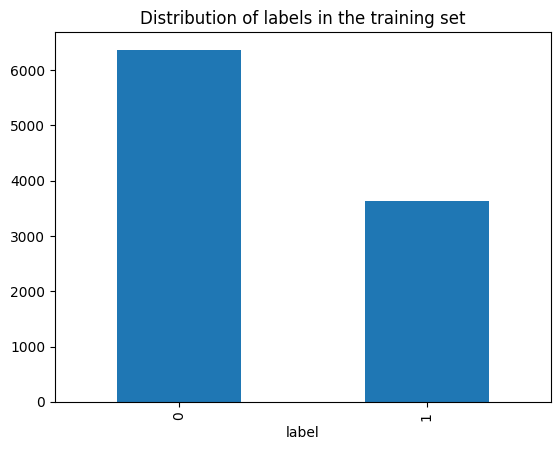

In [9]:
train_df.groupby(train_df['label']).count()['id'].plot(kind='bar', title='Distribution of labels in the training set')

In [112]:
class JigsawDataset(Dataset):
    def __init__(self, data_df, tokenizer):
        self.data = data_df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        comment = self.data.iloc[index]["text"]
        label = torch.tensor(self.data.iloc[index]['label'], dtype=torch.float).unsqueeze(0)
        
        token_list, attention_mask = self.text_to_token_and_mask(comment)

        return dict(index=index, ids=token_list, mask=attention_mask, labels=label)
    
    def text_to_token_and_mask(self, input_text):
        tokenization_dict = tokenizer.encode_plus(input_text,
                                add_special_tokens=True,
                                max_length=128,
                                padding='max_length',
                                truncation=True,
                                return_attention_mask=True,
                                return_tensors='pt')
        token_list = tokenization_dict["input_ids"].flatten()
        attention_mask = tokenization_dict["attention_mask"].flatten()
        return (token_list, attention_mask)

## Model

In [113]:
def set_lr(optim, lr):
    '''
    Set the learning rate in the optimizer
    '''
    for g in optim.param_groups:
        g['lr'] = lr
    return optim

In [229]:
# Transformer class and functions for models and predictions

class TransformerClassifierStack(nn.Module):
    def __init__(self, tr_model, nb_labels, dropout_prob=0.4, freeze=False):
        super().__init__()
        self.tr_model = tr_model

        # Stack features of 4 last encoders
        self.hidden_dim = tr_model.config.hidden_size * 4

        # hidden linear for the classification
        self.dropout = nn.Dropout(dropout_prob)
        self.hl = nn.Linear(self.hidden_dim, self.hidden_dim)

        # Last Linear for the classification
        self.last_l = nn.Linear(self.hidden_dim, nb_labels)

        # freeze all the parameters if necessary
        for param in self.tr_model.parameters():
            param.requires_grad = not freeze

        # init learning params of last layers
        torch.nn.init.xavier_uniform_(self.hl.weight)
        torch.nn.init.xavier_uniform_(self.last_l.weight)

    def forward(self, ids, mask):
        # ids = [batch_size, padded_seq_len]
        # mask = [batch_size, padded_seq_len]
        # mask: avoid to make self attention on padded data
        tr_output = self.tr_model(input_ids=ids,
                                  attention_mask=mask,
                                  output_hidden_states=True)

        # Get all the hidden states
        hidden_states = tr_output['hidden_states']

        # hs_* = [batch_size, padded_seq_len, 768]
        hs_1 = hidden_states[-1][:, 0, :]
        hs_2 = hidden_states[-2][:, 0, :]
        hs_3 = hidden_states[-3][:, 0, :]
        hs_4 = hidden_states[-4][:, 0, :]

        # features_vec = [batch_size, 768 * 4]
        features_vec = torch.cat([hs_1, hs_2, hs_3, hs_4], dim=-1)

        x = self.dropout(features_vec)
        x = self.hl(x)

        # x = [batch_size, 768 * 4]
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.last_l(x)
        
        # x = [batch_size, 1]
        return x

def load_roberta_model(nb_labels):
    '''
    Load RoBERTa model without any checkpoint
    RoBERTa for finetuning
    '''
    logger.info(f"transformers.RobertaTokenizer : roberta-base")
    logger.info(f"transformers.AutoModel : roberta-base")
    tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
    tr_model = transformers.AutoModel.from_pretrained('roberta-base')
    model = TransformerClassifierStack(tr_model, nb_labels, freeze=True)
    return model, tokenizer


def load_roberta_pretrained(model_path, optimizer_path, nb_labels, lr=2e-5):
    '''
    Load RoBERTa from checkout point (already trained on Hate Speech tasks)
    '''
    tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
    tr_model = transformers.AutoModel.from_pretrained('roberta-base')
    model = TransformerClassifierStack(tr_model, nb_labels)

    # loaded = torch.load(path)
    # model.load_state_dict(loaded['state_dict'])
    print(f'loading model from: {model_path}')
    model = torch.load(model_path, map_location=device)

    optimizer = transformers.AdamW(model.parameters(), lr=lr)
    # optimizer.load_state_dict(loaded['optimizer_dict'])
    if optimizer_path:
      print(f'loading optimizer from: {optimizer_path}')
      optimizer = torch.load(optimizer_path, map_location=device)
    optimizer = set_lr(optimizer, lr)

    return model, tokenizer, optimizer

def preds_fn(batch, model, device):
    '''
    Get the predictions for one batch according to the model
    '''
    b_input = batch['ids'].to(device)
    b_mask = batch['mask'].to(device)

    return model(b_input, b_mask)

In [230]:
# Load the model
# model, tokenizer = load_roberta_model(nb_labels=len(LABEL_LIST))
# model, tokenizer = load_roberta_model(nb_labels=1)

pretrained_path = "/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Statistical NLP/Assignment/aalto-snlp-project-spring-2024/session/roberta-fl_2024-03-17T20-22-46-379849/roberta-fl_2024-03-17T18-58-51-062923.model"
model, tokenizer, optimizer = load_roberta_pretrained(pretrained_path, None, nb_labels=1)
logger.success("Model loaded !")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loading model from: /Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Statistical NLP/Assignment/aalto-snlp-project-spring-2024/session/roberta-fl_2024-03-17T20-22-46-379849/roberta-fl_2024-03-17T18-58-51-062923.model


2024-03-17 22:14:21.459 | SUCCESS  | __main__:<module>:7 - Model loaded !


## Hyperparamètre

In [116]:
BATCH_SIZE = 320
LR=1e-4
PIN_MEMORY = True
NUM_WORKERS = 0
# PREFETCH_FACTOR = 2
PREFETCH_FACTOR = None
NUM_EPOCHS = 10
logger.info(f"{BATCH_SIZE=}")
logger.info(f"{LR=}")
logger.info(f"{PIN_MEMORY=}")
logger.info(f"{NUM_WORKERS=}")
logger.info(f"{PREFETCH_FACTOR=}")
logger.info(f"{NUM_EPOCHS=}")

2024-03-17 20:22:48.145 | INFO     | __main__:<module>:8 - BATCH_SIZE=64
2024-03-17 20:22:48.148 | INFO     | __main__:<module>:9 - LR=0.0001
2024-03-17 20:22:48.149 | INFO     | __main__:<module>:10 - PIN_MEMORY=True
2024-03-17 20:22:48.150 | INFO     | __main__:<module>:11 - NUM_WORKERS=0
2024-03-17 20:22:48.151 | INFO     | __main__:<module>:12 - PREFETCH_FACTOR=None
2024-03-17 20:22:48.152 | INFO     | __main__:<module>:13 - NUM_EPOCHS=1


### Loss

In [117]:
class FocalLoss(nn.Module):
    def __init__(self,
                 gamma: float = 2,
                 reduction: str = "mean",
                 pos_weight: torch.Tensor = None):
        super(FocalLoss, self).__init__()
        self.gamma= gamma
        self.reduction = reduction
        self.pos_weight = pos_weight

    def forward(self, inputs: torch.Tensor,
                targets: torch.Tensor):
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction="none", pos_weight=self.pos_weight
        )
        p_t =  p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

In [118]:
# Taken from: https://github.com/Roche/BalancedLossNLP

class ResampleLoss(nn.Module):

    def __init__(self,
                 use_sigmoid=True, partial=False,
                 loss_weight=1.0, reduction='mean',
                 reweight_func=None,  # None, 'inv', 'sqrt_inv', 'rebalance', 'CB'
                 weight_norm=None, # None, 'by_instance', 'by_batch'
                 focal=dict(
                     focal=True,
                     alpha=0.5,
                     gamma=2,
                 ),
                 map_param=dict(
                     alpha=10.0,
                     beta=0.2,
                     gamma=0.1
                 ),
                 CB_loss=dict(
                     CB_beta=0.9,
                     CB_mode='average_w'  # 'by_class', 'average_n', 'average_w', 'min_n'
                 ),
                 logit_reg=dict(
                     neg_scale=5.0,
                     init_bias=0.1
                 ),
                 class_freq=None,
                 train_num=None):
        super(ResampleLoss, self).__init__()

        assert (use_sigmoid is True) or (partial is False)
        self.use_sigmoid = use_sigmoid
        self.partial = partial
        self.loss_weight = loss_weight
        self.reduction = reduction
        if self.use_sigmoid:
            if self.partial:
                raise RuntimeError("Not defined here")
                self.cls_criterion = partial_cross_entropy
            else:
                self.cls_criterion = binary_cross_entropy
        else:
            raise RuntimeError("Not defined here")
            self.cls_criterion = cross_entropy

        # reweighting function
        self.reweight_func = reweight_func

        # normalization (optional)
        self.weight_norm = weight_norm

        # focal loss params
        self.focal = focal['focal']
        self.gamma = focal['gamma']
        self.alpha = focal['alpha'] # change to alpha

        # mapping function params
        self.map_alpha = map_param['alpha']
        self.map_beta = map_param['beta']
        self.map_gamma = map_param['gamma']

        # CB loss params (optional)
        self.CB_beta = CB_loss['CB_beta']
        self.CB_mode = CB_loss['CB_mode']

        self.class_freq = torch.from_numpy(np.asarray(class_freq)).float().cuda()
        self.num_classes = self.class_freq.shape[0]
        self.train_num = train_num # only used to be divided by class_freq
        # regularization params
        self.logit_reg = logit_reg
        self.neg_scale = logit_reg[
            'neg_scale'] if 'neg_scale' in logit_reg else 1.0
        init_bias = logit_reg['init_bias'] if 'init_bias' in logit_reg else 0.0
        # bug fixed https://github.com/wutong16/DistributionBalancedLoss/issues/8
        self.init_bias = - torch.log(
            self.train_num / self.class_freq - 1) * init_bias

        self.freq_inv = torch.ones(self.class_freq.shape).cuda() / self.class_freq
        self.propotion_inv = self.train_num / self.class_freq

    def forward(self,
                cls_score,
                label,
                weight=None,
                avg_factor=None,
                reduction_override=None,
                **kwargs):

        assert reduction_override in (None, 'none', 'mean', 'sum')
        reduction = (
            reduction_override if reduction_override else self.reduction)

        weight = self.reweight_functions(label)

        cls_score, weight = self.logit_reg_functions(label.float(), cls_score, weight)

        if self.focal:
            logpt = self.cls_criterion(
                cls_score.clone(), label, weight=None, reduction='none',
                avg_factor=avg_factor)
            # pt is sigmoid(logit) for pos or sigmoid(-logit) for neg
            pt = torch.exp(-logpt)
            wtloss = self.cls_criterion(
                cls_score, label.float(), weight=weight, reduction='none')
            alpha_t = torch.where(label==1, self.alpha, 1-self.alpha)
            loss = alpha_t * ((1 - pt) ** self.gamma) * wtloss # balance_param should be a tensor
            loss = reduce_loss(loss, reduction)             # add reduction
        else:
            loss = self.cls_criterion(cls_score, label.float(), weight,
                                      reduction=reduction)

        loss = self.loss_weight * loss
        return loss

    def reweight_functions(self, label):
        if self.reweight_func is None:
            return None
        elif self.reweight_func in ['inv', 'sqrt_inv']:
            weight = self.RW_weight(label.float())
        elif self.reweight_func in 'rebalance':
            weight = self.rebalance_weight(label.float())
        elif self.reweight_func in 'CB':
            weight = self.CB_weight(label.float())
        else:
            return None

        if self.weight_norm is not None:
            if 'by_instance' in self.weight_norm:
                max_by_instance, _ = torch.max(weight, dim=-1, keepdim=True)
                weight = weight / max_by_instance
            elif 'by_batch' in self.weight_norm:
                weight = weight / torch.max(weight)

        return weight

    def logit_reg_functions(self, labels, logits, weight=None): 
        if not self.logit_reg:
            return logits, weight
        if 'init_bias' in self.logit_reg:
            logits += self.init_bias
        if 'neg_scale' in self.logit_reg:
            logits = logits * (1 - labels) * self.neg_scale  + logits * labels
            if weight is not None:
                weight = weight / self.neg_scale * (1 - labels) + weight * labels
        return logits, weight

    def rebalance_weight(self, gt_labels):
        repeat_rate = torch.sum( gt_labels.float() * self.freq_inv, dim=1, keepdim=True)
        pos_weight = self.freq_inv.clone().detach().unsqueeze(0) / repeat_rate
        # pos and neg are equally treated
        weight = torch.sigmoid(self.map_beta * (pos_weight - self.map_gamma)) + self.map_alpha
        return weight

    def CB_weight(self, gt_labels):
        if  'by_class' in self.CB_mode:
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, self.class_freq)).cuda()
        elif 'average_n' in self.CB_mode:
            avg_n = torch.sum(gt_labels * self.class_freq, dim=1, keepdim=True) / \
                    torch.sum(gt_labels, dim=1, keepdim=True)
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, avg_n)).cuda()
        elif 'average_w' in self.CB_mode:
            weight_ = torch.tensor((1 - self.CB_beta)).cuda() / \
                      (1 - torch.pow(self.CB_beta, self.class_freq)).cuda()
            weight = torch.sum(gt_labels * weight_, dim=1, keepdim=True) / \
                     torch.sum(gt_labels, dim=1, keepdim=True)
        elif 'min_n' in self.CB_mode:
            min_n, _ = torch.min(gt_labels * self.class_freq +
                                 (1 - gt_labels) * 100000, dim=1, keepdim=True)
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, min_n)).cuda()
        else:
            raise NameError
        return weight

    def RW_weight(self, gt_labels, by_class=True):
        if 'sqrt' in self.reweight_func:
            weight = torch.sqrt(self.propotion_inv)
        else:
            weight = self.propotion_inv
        if not by_class:
            sum_ = torch.sum(weight * gt_labels, dim=1, keepdim=True)
            weight = sum_ / torch.sum(gt_labels, dim=1, keepdim=True)
        return weight
    

def reduce_loss(loss, reduction):
    """Reduce loss as specified.
    Args:
        loss (Tensor): Elementwise loss tensor.
        reduction (str): Options are "none", "mean" and "sum".
    Return:
        Tensor: Reduced loss tensor.
    """
    reduction_enum = F._Reduction.get_enum(reduction)
    # none: 0, elementwise_mean:1, sum: 2
    if reduction_enum == 0:
        return loss
    elif reduction_enum == 1:
        return loss.mean()
    elif reduction_enum == 2:
        return loss.sum()


def weight_reduce_loss(loss, weight=None, reduction='mean', avg_factor=None):
    """Apply element-wise weight and reduce loss.
    Args:
        loss (Tensor): Element-wise loss.
        weight (Tensor): Element-wise weights.
        reduction (str): Same as built-in losses of PyTorch.
        avg_factor (float): Avarage factor when computing the mean of losses.
    Returns:
        Tensor: Processed loss values.
    """
    # if weight is specified, apply element-wise weight
    if weight is not None:
        loss = loss * weight

    # if avg_factor is not specified, just reduce the loss
    if avg_factor is None:
        loss = reduce_loss(loss, reduction)
    else:
        # if reduction is mean, then average the loss by avg_factor
        if reduction == 'mean':
            loss = loss.sum() / avg_factor
        # if reduction is 'none', then do nothing, otherwise raise an error
        elif reduction != 'none':
            raise ValueError('avg_factor can not be used with reduction="sum"')
    return loss


def binary_cross_entropy(pred,
                         label,
                         weight=None,
                         reduction='mean',
                         avg_factor=None):

    # weighted element-wise losses
    if weight is not None:
        weight = weight.float()

    loss = F.binary_cross_entropy_with_logits(
        pred, label.float(), weight, reduction='none')
    loss = weight_reduce_loss(loss, reduction=reduction, avg_factor=avg_factor)

    return loss

In [119]:
def get_label_weights_bce(df, classes=LABEL_LIST):
    weights = torch.empty((len(classes),))

    nb_samples = len(df)

    for idx, c in enumerate(classes):
        nb_zeros = len(df[df[c] == 0])
        nb_ones = nb_samples - nb_zeros
        weights[idx] = nb_zeros / nb_ones

    return weights

def get_label_inv_freq(df, classes=LABEL_LIST):
    weights = torch.empty((len(classes),))
    nb_samples = len(df)

    for idx, c in enumerate(classes):
        nb_zeros = len(df[df[c] == 0])
        weights[idx] = (nb_zeros / nb_samples)

    return weights

def get_nb_samples_lab(df, classes=LABEL_LIST):
    nb_ones_tot, nb_zeros_tot = [], []
    nb_tot = len(df)

    for c in classes:
        nb_zeros = len(df[df[c] == 0])
        nb_ones = nb_tot - nb_zeros

        nb_ones_tot.append(nb_ones)
        nb_zeros_tot.append(nb_zeros)

    return torch.tensor(nb_ones_tot), torch.tensor(nb_zeros_tot)

### Instancier les différents objets

In [120]:
train_dataset = JigsawDataset(train_df, tokenizer)
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS,
                             prefetch_factor=PREFETCH_FACTOR,
                             pin_memory=PIN_MEMORY)

validation_dataset = JigsawDataset(validation_df, tokenizer)
validation_dataloader = DataLoader(validation_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS,
                             prefetch_factor=PREFETCH_FACTOR,
                             pin_memory=PIN_MEMORY)

# Pas besoin de Sigmoid en sorti du model seulement pour `BCEWithLogitsLoss`
criterion = FocalLoss()
logger.info(criterion)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
logger.info(optimizer)

model.to(device)
criterion.to(device)

2024-03-17 20:22:48.193 | INFO     | __main__:<module>:19 - FocalLoss()
2024-03-17 20:22:48.201 | INFO     | __main__:<module>:21 - AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


FocalLoss()

## Metric

### Variantes de Hamming Loss

In [121]:
class HammingLossWithoutThreshold(Metric):
    def __init__(self, num_classes=1, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.num_classes = num_classes

        self.add_state("total", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx="sum")
        self.add_state("nbr_sample", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        current_nbr_sample, current_nbr_category = preds.shape
        if current_nbr_category != self.num_classes:
          raise AttributeError("`num_classes` != `current_nbr_category` detected in `pred` parameter")
        
        current_loss_per_pred = torch.absolute(target - preds)
        current_hamming_loss = current_loss_per_pred.sum()

        self.total += current_hamming_loss.float()
        self.nbr_sample += current_nbr_sample

    def compute(self):
        return self.total/(self.num_classes*self.nbr_sample)

In [122]:
class RebalancedHammingLossWithoutThreshold(Metric):
    def __init__(self, num_classes=1, average="macro", dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.num_classes = num_classes

        # average = "macro" or None
        self.average = average

        # Nombre de positif 1 & negatif 0 par categorie
        self.add_state(
            "number_positive",
            default=torch.tensor([0 for _ in range(num_classes)]),
            dist_reduce_fx="sum",
        )
        self.add_state(
            "number_negative",
            default=torch.tensor([0 for _ in range(num_classes)]),
            dist_reduce_fx="sum",
        )

        self.add_state(
            "hamming_loss_positive",
            default=torch.tensor([0.0 for _ in range(num_classes)]),
            dist_reduce_fx="sum",
        )
        self.add_state(
            "hamming_loss_negative",
            default=torch.tensor([0.0 for _ in range(num_classes)]),
            dist_reduce_fx="sum",
        )

        self.add_state("nbr_sample", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        current_nbr_sample, current_nbr_category = preds.shape
        if current_nbr_category != self.num_classes:
            raise AttributeError(
                "`num_classes` != `current_nbr_category` detected in `pred` parameter"
            )

        # Nombre de positif 1 & negatif 0 par categorie
        current_number_positive = target.sum(axis=0)
        current_number_negative = current_nbr_sample - target.sum(axis=0)

        self.number_positive += current_number_positive.int()
        self.number_negative += current_number_negative.int()

        self.nbr_sample += current_nbr_sample

        for class_id in range(self.num_classes):
            positive_filter = target[:, class_id] == 1
            negative_filter = target[:, class_id] == 0

            target_vector = target[:, class_id]
            preds_vector = preds[:, class_id]

            # Filtered vector
            ## Target
            pos_filtered_target_vector = target_vector[positive_filter]
            neg_filtered_target_vector = target_vector[negative_filter]
            ## Preds
            pos_filtered_preds_vector = preds_vector[positive_filter]
            neg_filtered_preds_vector = preds_vector[negative_filter]

            # Hamming Loss without Threshold
            hamming_loss_on_positive = torch.absolute(
                pos_filtered_target_vector - pos_filtered_preds_vector
            )
            hamming_loss_on_negative = torch.absolute(
                neg_filtered_target_vector - neg_filtered_preds_vector
            )

            self.hamming_loss_positive[class_id] += hamming_loss_on_positive.sum()
            self.hamming_loss_negative[class_id] += hamming_loss_on_negative.sum()

    def compute(self):
        factor_pos = self.nbr_sample / (2 * self.number_positive)
        factor_neg = self.nbr_sample / (2 * self.number_negative)

        rebalanced_hamming_loss_per_class = torch.multiply(
            self.hamming_loss_positive, factor_pos
        ) + torch.multiply(self.hamming_loss_negative, factor_neg)
        if self.average == "macro":
            return rebalanced_hamming_loss_per_class.sum() / (
                self.nbr_sample * self.num_classes
            )
        return rebalanced_hamming_loss_per_class / (self.nbr_sample)


### Instanciation des metrics

In [123]:
# num_classes = len(LABEL_LIST)
num_classes = 1
train_metric_dict = dict()

# AUROC Macro
auroc_macro = AUROC(num_classes=num_classes, compute_on_step=True, average="macro")
train_metric_dict["auroc_macro"] = auroc_macro

# AUROC per class
auroc_per_class = AUROC(num_classes=num_classes, compute_on_step=True, average=None)
train_metric_dict["auroc_per_class"] = auroc_per_class

# F1 score global
f1 = F1Score()
train_metric_dict["f1"] = f1

# F1 score per class
f1_per_calss = F1Score(num_classes=num_classes, average=None)
train_metric_dict["f1_per_calss"] = f1_per_calss

# Hamming Distance without Threshold
hamming_loss_woutt = HammingLossWithoutThreshold(num_classes=num_classes)
train_metric_dict["hamming_loss_without_threshold"] = hamming_loss_woutt

# Rebalanced Hamming Distance without Threshold macro
rebalanced_hamming_loss_woutt_macro = RebalancedHammingLossWithoutThreshold(
    num_classes=num_classes, average="macro"
)
train_metric_dict[
    "rebalanced_hamming_loss_without_threshold_macro"
] = rebalanced_hamming_loss_woutt_macro

# Rebalanced Hamming Distance without Threshold macro
rebalanced_hamming_loss_woutt_per_class = RebalancedHammingLossWithoutThreshold(
    num_classes=num_classes, average=None
)
train_metric_dict[
    "rebalanced_hamming_loss_without_threshold_per_class"
] = rebalanced_hamming_loss_woutt_per_class

In [124]:
train_metric = MetricCollection(train_metric_dict)
train_metric.to(device)

validation_metric = train_metric.clone()
validation_metric.to(device)

MetricCollection(
  (auroc_macro): AUROC()
  (auroc_per_class): AUROC()
  (f1): F1Score()
  (f1_per_calss): F1Score()
  (hamming_loss_without_threshold): HammingLossWithoutThreshold()
  (rebalanced_hamming_loss_without_threshold_macro): RebalancedHammingLossWithoutThreshold()
  (rebalanced_hamming_loss_without_threshold_per_class): RebalancedHammingLossWithoutThreshold()
)

### Export metrics

In [125]:
def serialize(object_to_serialize: Any, ensure_ascii: bool = True) -> str:
    """
    Serialize any object, i.e. convert an object to JSON
    Args:
        object_to_serialize (Any): The object to serialize
        ensure_ascii (bool, optional): If ensure_ascii is true (the default), the output is guaranteed to have all incoming non-ASCII characters escaped. If ensure_ascii is false, these characters will be output as-is. Defaults to True.
    Returns:
            str: string of serialized object (JSON)
    """

    def dumper(obj: Any) -> Union[str, Dict]:
        """
        Function called recursively by json.dumps to know how to serialize an object.
        For example, for datetime, we try to convert it to ISO format rather than
        retrieve the list of attributes defined in its object.
        Args:
            obj (Any): The object to serialize
        Returns:
            Union[str, Dict]: Serialized object
        """
        if isinstance(obj, torch.Tensor):
            return obj.cpu().numpy().tolist()
        elif hasattr(obj, "__dict__"):
            return obj.__dict__
        return str(obj)

    return json.dumps(object_to_serialize, default=dumper, ensure_ascii=ensure_ascii)

In [126]:
def export_metric(metric_collection, **kwargs):
    """
    Export MetricCollection to json file

    Args:
        metric_collection: MetricCollection
        **kwargs: field to add in json line
    """
    with open(METRIC_FILE_PATH, "a") as f:
        metric_collection_value = metric_collection.compute()
        metric_collection_value.update(kwargs)
        serialized_value = serialize(metric_collection_value)
        f.write(serialized_value)
        f.write("\n")
    logger.success("Metrics are exported !")

## Entraînement

In [127]:
def train_epoch(epoch_id=None):
    model.train()
    logger.info(f"START EPOCH {epoch_id=}")

    progress = tqdm(train_dataloader, desc='training batch...', leave=False)
    for batch_id, batch in enumerate(progress):
        if batch_id % 1_000 == 0:
            valid_epoch(epoch_id=epoch, batch_id=batch_id)
        
        logger.trace(f"{batch_id=}")
        token_list_batch = batch["ids"].to(device)
        attention_mask_batch = batch["mask"].to(device)
        # convert [batch_size, 1] to [batch_size]
        label_batch = batch["labels"].squeeze().to(device)

        # Reset gradient
        optimizer.zero_grad()

        # Predict
        prediction_batch = model(token_list_batch, attention_mask_batch)
        transformed_prediction_batch = prediction_batch.squeeze()

        # Loss
        loss = criterion(transformed_prediction_batch.to(torch.float32), label_batch.to(torch.float32))

        # Metrics
        proba_prediction_batch = torch.sigmoid(transformed_prediction_batch)
        proba_prediction_batch = proba_prediction_batch.unsqueeze(1)
        label_batch = label_batch.unsqueeze(1)
        train_metrics_collection_dict = train_metric(proba_prediction_batch.to(torch.float32), label_batch.to(torch.int32))
        logger.trace(train_metrics_collection_dict)

        # Backprop        
        loss.backward()
        # gradient clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update progress bar description
        progress_description = "Train Loss : {loss:.4f} - Train AUROC : {acc:.4f}"
        auroc_macro_value = float(train_metrics_collection_dict["auroc_macro"])
        progress_description = progress_description.format(loss=loss.item(), acc=auroc_macro_value)
        progress.set_description(progress_description)

    logger.info(f"END EPOCH {epoch_id=}")

In [128]:
@torch.no_grad()
def valid_epoch(epoch_id=None, batch_id=None):
    model.eval()
    logger.info(f"START VALIDATION {epoch_id=}{batch_id=}")
    validation_metric.reset()

    loss_list = []
    prediction_list = torch.Tensor([])
    target_list = torch.Tensor([])


    progress = tqdm(validation_dataloader, desc="valid batch...", leave=False)
    for _, batch in enumerate(progress):
        
        token_list_batch = batch["ids"].to(device)
        attention_mask_batch = batch["mask"].to(device)
        # convert label_batch shape from [batch_size, 1] to [batch_size]
        label_batch = batch["labels"].squeeze().to(device)

        # Predict
        prediction_batch = model(token_list_batch, attention_mask_batch)

        transformed_prediction_batch = prediction_batch.squeeze()

        # Loss
        loss = criterion(
            transformed_prediction_batch.to(torch.float32),
            label_batch.to(torch.float32),
        )

        loss_list.append(loss.item())

        proba_prediction_batch = torch.sigmoid(transformed_prediction_batch)
        prediction_list = torch.concat(
            [prediction_list, proba_prediction_batch.cpu()]
        )
        target_list = torch.concat([target_list, label_batch.cpu()])

        # Metrics
        # convert shape from [batch_size] to [batch_size, 1]
        proba_prediction_batch = proba_prediction_batch.unsqueeze(1)
        label_batch = label_batch.unsqueeze(1)
        validation_metric(proba_prediction_batch.to(torch.float32), label_batch.to(torch.int32))

    loss_mean = np.mean(loss_list)
    logger.trace(validation_metric.compute())
    logger.info(f"END VALIDATION {epoch_id=}{batch_id=}")
    export_metric(validation_metric, epoch_id=epoch_id, batch_id=batch_id, loss=loss_mean)

In [129]:
# torch.cuda.empty_cache()
progress =  tqdm(range(1,NUM_EPOCHS+1), desc='training epoch...', leave=True)
for epoch in progress:
    # Train
    train_epoch(epoch_id=epoch)
    
    # Validation
    valid_epoch(epoch_id=epoch)

    # Save
    torch.save(model, MODEL_FILE_PATH)

training epoch...:   0%|          | 0/1 [00:00<?, ?it/s]2024-03-17 20:22:48.815 | INFO     | __main__:train_epoch:3 - START EPOCH epoch_id=1
2024-03-17 20:22:48.851 | INFO     | __main__:valid_epoch:4 - START VALIDATION epoch_id=1batch_id=0














































































































































































2024-03-17 20:26:08.862 | INFO     | __main__:valid_epoch:47 - END VALIDATION epoch_id=1batch_id=0
2024-03-17 20:26:08.865 | SUCCESS  | __main__:export_metric:15 - Metrics are exported !
2024-03-17 20:52:28.943 | INFO     | __main__:valid_epoch:4 - START VALIDATION epoch_id=1batch_id=1000














































































































































































2024-03-17 20:57:04.316 | INFO     | __main__:valid_epoch:47 - END VALIDATION epoch_id=1batch_id=1000
2024-03-17 20:57:04

KeyboardInterrupt: 

## Evaluation

In [27]:
try:
    del train_df
    del validation_df
except NameError:
    logger.warning("Train DataFrame & Validation DataFrame already deleted")

In [188]:
tmp = pd.read_csv('../../sample_submission_2024.csv')
tmp.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [176]:
test_df = pd.read_csv(TEST_DATASET_PATH, quoting=3)

In [177]:
test_df['label'] = 0

# Take only 1000 samples
test_df.head()

,id,text,label
0,0,I get the odd feeling Klastri the head of the...,0
1,1,I couldn't disagree more with this column; Can...,0
2,2,Does the property owner have a vote in the ta...,0
3,3,Shawn do you think it may be due to the fact ...,0
4,4,You proved she turned over 100% of the relevan...,0


In [178]:
test_df.shape

(12001, 3)

In [157]:
test_dataset = JigsawDataset(test_df, tokenizer)
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [209]:
@torch.no_grad()
def evaluation(model):
    model.eval()
    logger.info(f"START EVALUATION")

    index_tensor = torch.Tensor([])
    prediction_tensor = torch.Tensor([])

    progress = tqdm(test_dataloader, desc='test batch...', leave=False)
    for batch_id, batch in enumerate(progress):
        logger.trace(f"{batch_id=}")
        index_batch = batch["index"].to(device)
        token_list_batch = batch["ids"].to(device)
        attention_mask_batch = batch["mask"].to(device)
        label_batch = batch["labels"].to(device)

        # Predict
        prediction_batch = model(token_list_batch, attention_mask_batch)
        transformed_prediction_batch = prediction_batch.squeeze()
        proba_prediction_batch = torch.sigmoid(transformed_prediction_batch)
        
        index_tensor = torch.concat([index_tensor, index_batch.cpu()])
        prediction_tensor = torch.concat([prediction_tensor, proba_prediction_batch.cpu()])
        # print(f'probabilities : {proba_prediction_batch}')
        # print(f'probabilities shape : {proba_prediction_batch.shape}')
    
    logger.info(f"END EVALUATION")
    prediction_test_df = pd.DataFrame((prediction_tensor > 0.5).int().tolist(), 
                                     columns=['label'],
                                     index=index_tensor.to(int).tolist(),
                                     )
    # rename index column as id
    prediction_test_df.index.name = 'id'
    prediction_test_df.to_csv(TEST_FILE_PATH)
    print(prediction_test_df)
    logger.success(f"Test predictions exported !")

In [210]:
evaluation(model)

2024-03-17 21:36:03.223 | INFO     | __main__:evaluation:4 - START EVALUATION
2024-03-17 21:36:05.311 | INFO     | __main__:evaluation:27 - END EVALUATION
2024-03-17 21:36:05.316 | SUCCESS  | __main__:evaluation:36 - Test predictions exported !


    label
id       
0       0
1       0
2       0
3       0
4       0
..    ...
95      0
96      0
97      1
98      0
99      0

[100 rows x 1 columns]


In [244]:
# import precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
# Compute Precision, Recall, and F1 Score of the imported predicted csv and the validation df
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

# Load the predicted csv
y_pred = pd.read_csv('../../dev_prediction/dev_new2.csv', index_col=0)
y_pred = y_pred['label'].tolist()

# Load the validation df
y_true = pd.read_csv('/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Statistical NLP/Assignment/aalto-snlp-project-spring-2024/dev_2024.csv', quoting=3)
y_true = y_true['label'].tolist()

# Compute the metrics
precision, recall, f1 = compute_metrics(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Precision: 0.8688887307573709
Recall: 0.8478550290113973
F1: 0.8564232189061318


In [26]:


# each model takes in either a string or a list of strings

result = model.predict(['example text', 'example text'])
result

{'toxicity': [0.000647831242531538, 0.000647831242531538],
 'severe_toxicity': [0.00012098397564841434, 0.00012098397564841434],
 'obscene': [0.00018694325990509242, 0.00018694325990509242],
 'threat': [0.0001162407934316434, 0.0001162407934316434],
 'insult': [0.00018111889949068427, 0.00018111889949068427],
 'identity_attack': [0.00014001900854054838, 0.00014001900854054838]}

In [60]:
import tqdm
from detoxify import Detoxify

results = {
	'toxicity': [],
	'severe_toxicity': [],
	'obscene': [],
	'threat': [],
	'insult': [],
	'identity_attack': []
}
model = Detoxify('multilingual', device='cpu')
seqs = test_df['text'].tolist()

batch_size = 100
for i in tqdm.tqdm(range(len(seqs))):
	result = model.predict(seqs[i])
	for k in results:
		results[k].append(result[k])

# Create a (n, 6) matrix from the results
import numpy as np
results_matrix = np.array([results[k] for k in results]).T
results_matrix.shape

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.4-alpha/multilingual_debiased-0b549669.ckpt" to /Users/lgk1910/.cache/torch/hub/checkpoints/multilingual_debiased-0b549669.ckpt
100%|██████████| 1.04G/1.04G [01:02<00:00, 17.8MB/s]
100%|██████████| 12001/12001 [09:04<00:00, 22.03it/s]


(12001, 6)

In [58]:
# Loop through the results and check if any of the labels are above 0.5
# If so, set the label to 1, otherwise 0
# apply OR operations to the columns of the matrix >= 0.5
processed_results = (results_matrix >= 0.5).any(axis=1).astype(int)

# Save the results to a csv
saved_df = test_df.copy()
# drop the text column
saved_df.drop(columns='text', inplace=True)
# add the processed results
saved_df['label'] = processed_results
saved_df.to_csv('../../submission/detoxify_submission.csv', index=False)


## Exporter les prédictions de la dataset de validation

In [33]:
@torch.no_grad()
def export_validation(model):
    model.eval()
    logger.info(f"START GET PREDICTION ON VALIDATION DATASET")

    index_tensor = torch.Tensor([])
    prediction_tensor = torch.Tensor([])
    label_tensor = torch.Tensor([])

    progress = tqdm(validation_dataloader, desc='valid batch...', leave=False)
    for batch_id, batch in enumerate(progress):
        logger.trace(f"{batch_id=}")
        index_batch = batch["index"].to(device)
        token_list_batch = batch["ids"].to(device)
        attention_mask_batch = batch["mask"].to(device)
        label_batch = batch["labels"].to(device)

        # Predict
        prediction_batch = model(token_list_batch, attention_mask_batch)
        transformed_prediction_batch = prediction_batch.squeeze()
        proba_prediction_batch = torch.sigmoid(transformed_prediction_batch)
        
        index_tensor = torch.concat([index_tensor, index_batch.cpu()])
        prediction_tensor = torch.concat([prediction_tensor, proba_prediction_batch.cpu()])
        label_tensor = torch.concat([label_tensor, label_batch.cpu()])
    
    logger.info(f"END GET PREDICTION ON VALIDATION DATASET")
    prediction_valid_df = pd.DataFrame(prediction_tensor.tolist(), 
                                     columns=LABEL_LIST,
                                     index=index_tensor.to(int).tolist())
    label_valid_df = pd.DataFrame(label_tensor.tolist(), 
                                     columns=LABEL_LIST,
                                     index=index_tensor.to(int).tolist())
    prediction_valid_df.to_csv(VALIDATION_FILE_PATH)
    label_valid_df.to_csv(VALIDATION_DATASET_FILE_PATH)
    logger.success(f"Validation predictions exported !")
export_validation(model)

2022-03-30 01:13:31.374 | INFO     | __main__:export_validation:4 - START GET PREDICTION ON VALIDATION DATASET


valid batch...:   0%|          | 0/313 [00:00<?, ?it/s]

2022-03-30 01:14:20.205 | INFO     | __main__:export_validation:27 - END GET PREDICTION ON VALIDATION DATASET
2022-03-30 01:14:20.346 | SUCCESS  | __main__:export_validation:36 - Validation predictions exported !
